<a href="https://colab.research.google.com/github/parkminhyung/python-code-for-finance/blob/main/portfolio%20optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- load required packages

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

- set parameters
- we create 5000 random portfolios
- the actual risk-free rate in real market is not "0", but we supposed that its value is 0
- init_asset is amount of asset

In [ ]:
tickers = ['AAPL','MSFT','TSLA','AMZN','GOOG','2222.SR']
num_port = 5000 #the number of random portfolio
rf = 0 #risk-free rate, the actual risk free rate is not "0",
init_asset = 100000

- create empty data frame and put stock value into the dataframe
- preprocess na value

In [ ]:
df = pd.DataFrame()
for ticker in tickers :
  data = yf.download(
    ticker,
    start  = "2020-01-01",
    end = "2023-01-01")
  price = data[["Adj Close"]]
  price = price.apply(lambda x: np.diff(np.log(x)))
  price.columns = [ticker]
  df = pd.concat([df,price],axis=1)

df = (np.round(df,5)).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


- calculate portfolios' return and covariance

In [ ]:
mean_return = df.mean()
cov_mat = df.cov()*252

- Create Random weights Portfolio

In [ ]:
all_wts = pd.DataFrame(np.zeros((num_port, df.shape[1])))
all_wts.columns = [ticker + "_weights"  for ticker in tickers]
for i in range(num_port) :
  all_wts.iloc[i] = np.random.uniform(low=0.0, high=1.0, size=df.shape[1])
  all_wts.iloc[i] = all_wts.iloc[i]/np.sum(all_wts.iloc[i])
all_wts

,AAPL_weights,MSFT_weights,TSLA_weights,AMZN_weights,GOOG_weights,2222.SR_weights
0,0.082464,0.225159,0.184827,0.212246,0.171522,0.123782
1,0.277499,0.043139,0.030742,0.127068,0.187135,0.334417
2,0.197338,0.352987,0.093610,0.009490,0.157644,0.188931
3,0.285555,0.007238,0.242699,0.203167,0.116021,0.145320
4,0.044204,0.134768,0.252585,0.209102,0.255386,0.103954
...,...,...,...,...,...,...
4995,0.163310,0.059597,0.176818,0.386949,0.006588,0.206738
4996,0.208766,0.097362,0.428216,0.065869,0.036320,0.163467
4997,0.222805,0.112242,0.223701,0.200724,0.191092,0.049435
4998,0.124188,0.180036,0.170719,0.188159,0.195205,0.141694


- Create return, risk, sharpe-ratio columns and calculate those values

In [ ]:
all_wts["return"], all_wts["risk"], all_wts["sharpe"] = (np.zeros((num_port, 1)) for _ in range(3))
for i in range(num_port) :
  all_wts["return"][i] = pow((1+np.array(all_wts.iloc[i,:len(tickers)]).dot(mean_return)),252)-1
  all_wts["risk"][i] = np.sqrt(np.array(all_wts.iloc[i,:len(tickers)]).dot(cov_mat.dot(np.array(all_wts.iloc[i,:len(tickers)]))))
all_wts["sharpe"] = (all_wts["return"]-rf)/all_wts["risk"]
all_wts

,AAPL_weights,MSFT_weights,TSLA_weights,AMZN_weights,GOOG_weights,2222.SR_weights,return,risk,sharpe
0,0.082464,0.225159,0.184827,0.212246,0.171522,0.123782,0.178217,0.321742,0.553913
1,0.277499,0.043139,0.030742,0.127068,0.187135,0.334417,0.120799,0.238430,0.506640
2,0.197338,0.352987,0.093610,0.009490,0.157644,0.188931,0.183094,0.286453,0.639177
3,0.285555,0.007238,0.242699,0.203167,0.116021,0.145320,0.220740,0.338230,0.652633
4,0.044204,0.134768,0.252585,0.209102,0.255386,0.103954,0.203539,0.345767,0.588659
...,...,...,...,...,...,...,...,...,...
4995,0.163310,0.059597,0.176818,0.386949,0.006588,0.206738,0.145639,0.309954,0.469872
4996,0.208766,0.097362,0.428216,0.065869,0.036320,0.163467,0.342554,0.404517,0.846822
4997,0.222805,0.112242,0.223701,0.200724,0.191092,0.049435,0.212273,0.353675,0.600193
4998,0.124188,0.180036,0.170719,0.188159,0.195205,0.141694,0.176423,0.312554,0.564454


- "tang" is tangency portfolio that has the largest sharpe ratio value
- "risk-min" is minimized risk portfolio that has the smallest risk value

In [ ]:
tang = all_wts.iloc[all_wts["sharpe"].idxmax()]
risk_min = all_wts.iloc[all_wts["risk"].idxmin()]


- show weights and allocation of tangency portfolio

In [ ]:
print( "[ tangency portfolio % ]" ,"\n" ,tang.iloc[:len(tickers)],"\n","\n",
"[ asset allocation $]","\n",">> Initial Asset : ",init_asset,"\n",tang.iloc[:len(tickers)] * init_asset)


[ tangency portfolio % ] 
 AAPL_weights       0.126427
MSFT_weights       0.002804
TSLA_weights       0.412961
AMZN_weights       0.010304
GOOG_weights       0.012470
2222.SR_weights    0.435033
Name: 3573, dtype: float64 
 
 [ asset allocation $] 
 >> Initial Asset :  100000 
 AAPL_weights       12642.712054
MSFT_weights         280.446726
TSLA_weights       41296.103834
AMZN_weights        1030.439891
GOOG_weights        1247.042534
2222.SR_weights    43503.254961
Name: 3573, dtype: float64


- show weights and allocation of risk-min portfolio

In [ ]:
#global minimize portfolio
print( "[ global minimize portfolio %]" ,"\n",risk_min.iloc[:len(tickers)],"\n","\n",
"[ asset allocation $]","\n",">> Initial Asset : ",init_asset,"\n",risk_min.iloc[:len(tickers)] * init_asset)



[ global minimize portfolio %] 
 AAPL_weights       0.043017
MSFT_weights       0.102193
TSLA_weights       0.039165
AMZN_weights       0.008121
GOOG_weights       0.231541
2222.SR_weights    0.575964
Name: 3084, dtype: float64 
 
 [ asset allocation $] 
 >> Initial Asset :  100000 
 AAPL_weights        4301.657387
MSFT_weights       10219.264254
TSLA_weights        3916.494898
AMZN_weights         812.107957
GOOG_weights       23154.124214
2222.SR_weights    57596.351290
Name: 3084, dtype: float64


- Visualize random portfolio and create annotations (global minimized portfolio and tangency portfolio)

In [ ]:
ann_min = go.layout.Annotation(
    x=risk_min['risk'],
    y=risk_min['return'],
    text="Minimum Variance Portfolio",
    xref="x",
    yref="y",
    showarrow=True,
    arrowhead=0
)

ann_tang = go.layout.Annotation(
    x=tang['risk'],
    y=tang['return'],
    text="Tangency Portfolio",
    xref="x",
    yref="y",
    showarrow=True,
    arrowhead=0
)

# Define layout for titles
title1 = {
    'text': "<b> Portfolio Optimization and Efficient Frontier </b>",
    'xref': "paper",
    'yref': "paper",
    'xanchor': "center",
    'yanchor': "bottom",
    'align': "center",
    'x': 0.5,
    'y': 1,
    'showarrow': False
}

title2 = {
    'text': "<b> Portfolio Weights </b>",
    'xref': "paper",
    'yref': "paper",
    'xanchor': "center",
    'yanchor': "bottom",
    'align': "center",
    'x': 0.5,
    'y': 1,
    'showarrow': False
}

# Create a subplot with two figures
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=all_wts['risk'],
    y=all_wts['return'],
    mode='markers',
    marker=dict(
        color=all_wts['sharpe'],
        colorscale='Viridis',
        showscale=True
    ),
    showlegend=False
))

fig1.add_trace(go.Scatter(
    x=[risk_min['risk']],
    y=[risk_min['return']],
    mode='markers',
    marker=dict(color="#A52929"),
))

fig1.add_trace(go.Scatter(
    x=[tang['risk']],
    y=[tang['return']],
    mode='markers',
    marker=dict(color="#A52929"),
))

fig1.update_xaxes(title="σ", zeroline=False)
fig1.update_yaxes(title="µ", zeroline=False)
fig1.update_layout(annotations=[title1, ann_min, ann_tang], coloraxis_colorbar=dict(title="Sharpe Ratio"))
fig1.show()

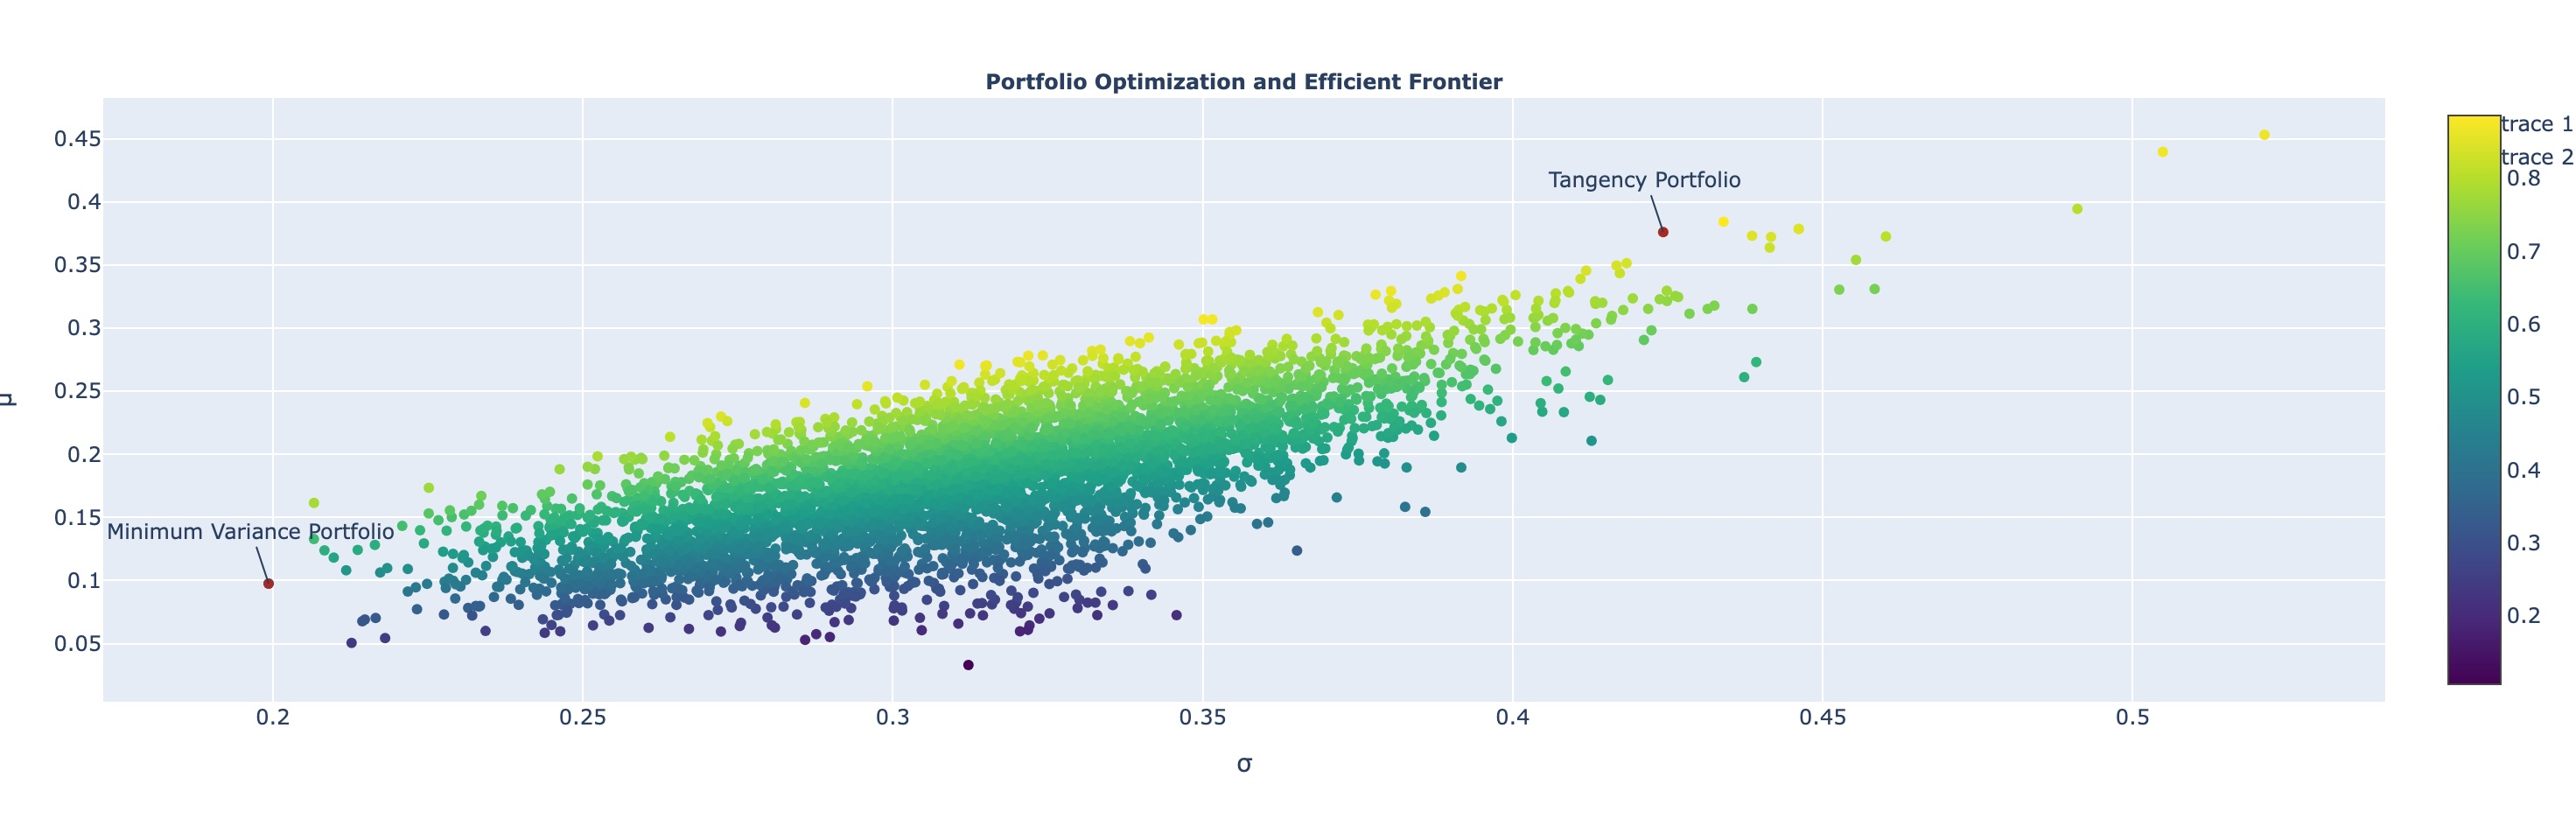

- build weights plots from portfolios

In [ ]:
fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x= risk_min.iloc[:len(tickers)].index,
    y= risk_min.iloc[:len(tickers)],
    name="Minimum Weights",
    marker=dict(color='#3246AB')
))

fig2.add_trace(go.Bar(
    x=tang.iloc[:len(tickers)].index,
    y=tang.iloc[:len(tickers)],
    name="Tangency Weights",
    marker=dict(color='#12B7C3')
))

fig2.update_layout(annotations=[title2], yaxis=dict(title="Weights"), barmode="group")
fig2.show()

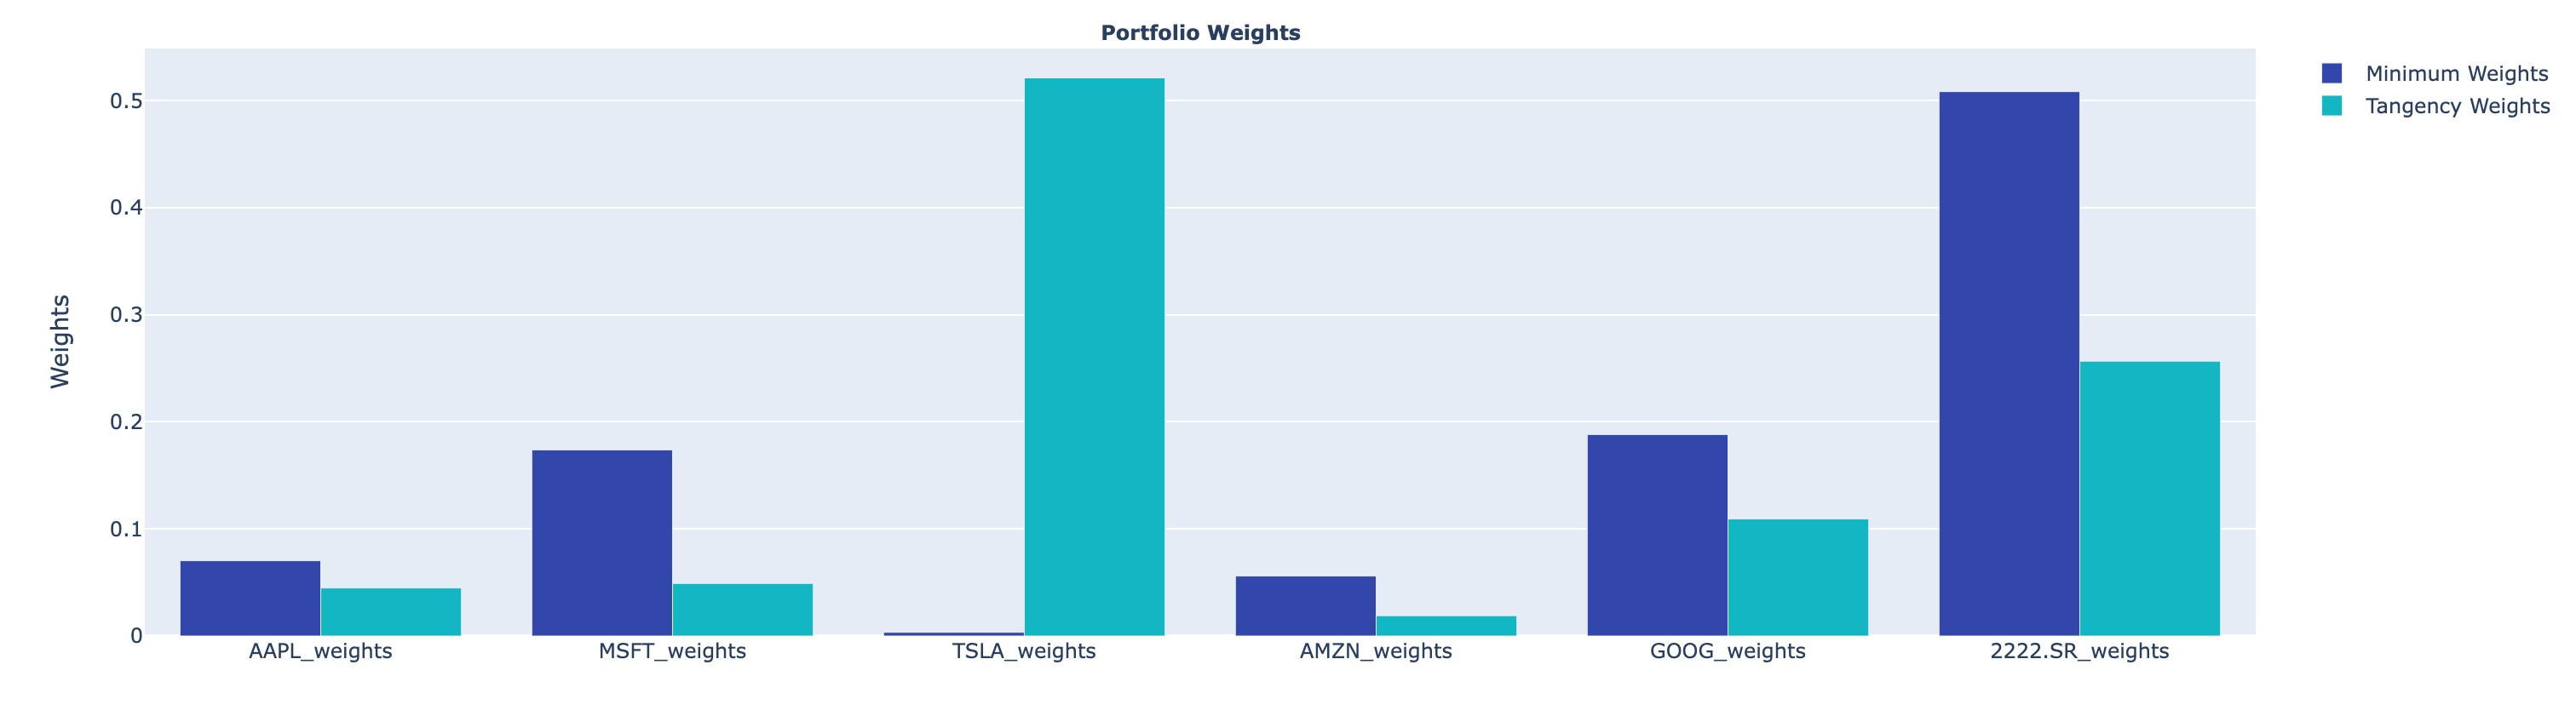

- merge two plots by making subplots

In [ ]:
# Create subplots
subplots = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("<b> Portfolio Optimization and Efficient Frontier </b>", "<b> Portfolio Weights </b>"))
for trace in fig1.data : subplots.add_trace(trace, row=1,col=1)
for trace in fig2.data : subplots.add_trace(trace, row=2,col=1)
subplots.update_layout(title_x=0.5, title_y=1, margin=dict(b=0.1))
subplots.show()

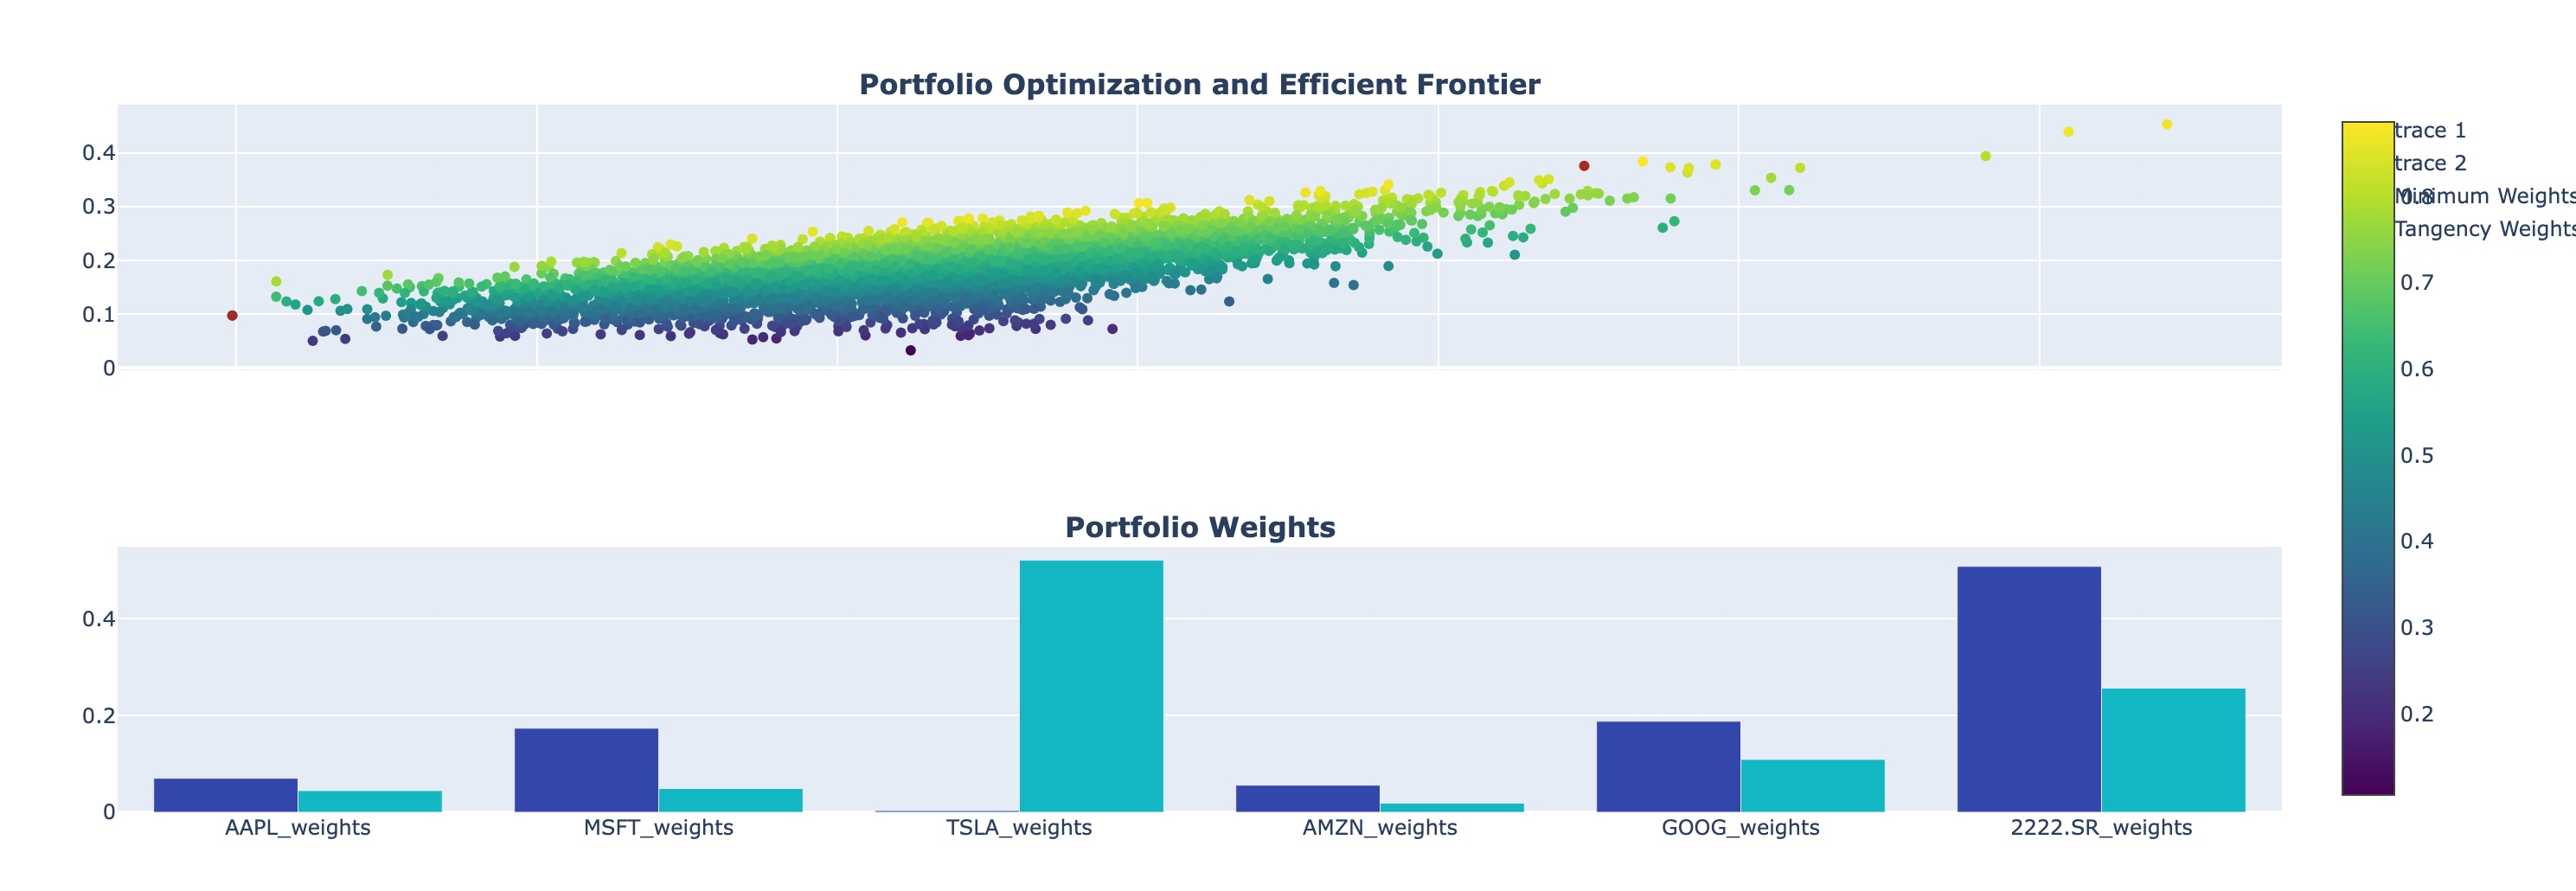